In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import pandas as pd
import scipy
from collections import defaultdict
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import norm
#import seaborn as sns
import pickle
import csv


#Bayesian LSTM requirements
""" !pip install blitz-bayesian-pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator """

' !pip install blitz-bayesian-pytorch\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.optim as optim\nfrom blitz.modules import BayesianLSTM\nfrom blitz.utils import variational_estimator '

In [10]:
#Original Data Extraction
#DATASET_PATH = '/content/drive/MyDrive/ADPM-uncertainty-quantification-main/Data-for-Project.csv'
DATASET_PATH = './Data-for-Project.csv'
dataset = pd.read_csv(DATASET_PATH, encoding="ISO-8859-1", dtype={"RID": float, "VISCODE": "string", "AGE": float, "PTGENDER": float, "PTEDUCAT": float, "APOE4": float, "ABETA": float, "TAU": float, "Ventricles": float, "Hippocampus": float,
  "WholeBrain": float, "Entorhinal": float, "Fusiform": float,  "MidTemp": float, "ICV": float,"ADAS11": float, "ADAS13": float,  "MMSE": float, "DX": float,})

#DX for diagnosis
features = ['RID', 'VISCODE', 'AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'ABETA', 'TAU', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX', 'MMSE']
labels = ['RID', 'VISCODE', 'MMSE']
cols = ['RID', 'VISCODE', 'AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'ABETA', 'TAU', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX', 'MMSE']
df = pd.DataFrame(dataset, columns=cols)
vis_codes = sorted(df.VISCODE.unique(), key=lambda x: (len(x), x)) 
vis_codes_counts = df.VISCODE.value_counts()
patient_codes = df.RID.unique()
print(df.head())
print(vis_codes)
print(vis_codes_counts)
print(type(vis_codes_counts))
print('patient_codes', len(patient_codes))

   RID VISCODE   AGE  PTGENDER  PTEDUCAT  APOE4  ABETA    TAU  Ventricles  \
0  2.0      bl  74.3       0.0      16.0    0.0    NaN    NaN    118233.0   
1  3.0      bl  81.3       0.0      18.0    1.0  741.5  239.7     84599.0   
2  3.0     m06  81.3       0.0      18.0    1.0    NaN    NaN     88580.0   
3  3.0     m12  81.3       0.0      18.0    1.0  601.4  251.7     90099.0   
4  3.0     m24  81.3       0.0      18.0    1.0    NaN    NaN     97420.0   

   Hippocampus  WholeBrain  Entorhinal  Fusiform  MidTemp        ICV   DX  \
0       8336.0   1229740.0      4177.0   16559.0  27936.0  1984660.0  0.0   
1       5319.0   1129830.0      1791.0   15506.0  18422.0  1920690.0  2.0   
2       5446.0   1100060.0      2427.0   14400.0  16972.0  1906430.0  2.0   
3       5157.0   1095640.0      1596.0   14617.0  17330.0  1903820.0  2.0   
4       5139.0   1088560.0      1175.0   14033.0  16398.0  1903420.0  2.0   

   MMSE  
0  28.0  
1  20.0  
2  24.0  
3  17.0  
4  19.0  
['bl', 'm03', 

In [11]:
#Transform data to time steps with format: [RID VISCODE AGE PTGENDER APOE4 Ventricles Hippocampus WholeBrain Entorhinal Fusiform MidTemp ADAS11 ADAS11, ADAS13, MMSE]
def getDefaultMap():
    return [[vis_codes[i]] for i in range(len(vis_codes))]

timestepIndex = {}
for i in range(len(vis_codes)):
    timestepIndex[vis_codes[i]] = i

patientsDf = defaultdict(getDefaultMap)

for i, row in df.iterrows():
    patientsDf[row['RID']][timestepIndex[row['VISCODE']]] = list(row)

#populate data into a list of patients with all the available timesteps
patientsDataAll = []
for patient in patientsDf.keys():
    for i in range(len(vis_codes)):
        if len(patientsDf[patient][i]) == 1:
            patientsDf[patient][i] = [patient] + patientsDf[patient][i]
        patientsDataAll.append(patientsDf[patient][i])

In [12]:
#find number number of patients for each number of records
conditionSet = ['bl', 'm12', 'm24', 'm36', 'm48','m60', 'm72','m84', 'm96', 'm108', 'm120', 'm132','m144', 'm156']
MIN_SEQUENCES = 3
patientsSequences = defaultdict(set)

def hasAllEntries(arr):
    return not pd.DataFrame(arr).isnull().any().any()

def getPatientsWithNTimeSteps(n):
    patientsData = {}
    for patient in patientsDf.keys():
        currPatient = []

        for condition in conditionSet:
            i = timestepIndex[condition]
            if len(patientsDf[patient][i]) == len(cols):
                currPatient.append(patientsDf[patient][i])
                if len(currPatient) == n:
                    break
            else:
                currPatient = []
        
        if len(currPatient) == n:
            patientsData[patient] = currPatient

    return patientsData

seqs = []
for n in range(MIN_SEQUENCES, len(conditionSet)):
    patientsSequences[n] = getPatientsWithNTimeSteps(n)
    seqs.append([n, len(patientsSequences[n])])

print('Number of Patients for each sequence', seqs)


""" newDf = pd.DataFrame(patientsData, columns = cols) 

newDf.to_csv('data_in_timesteps.csv', index=False) """

Number of Patients for each sequence [[3, 1267], [4, 819], [5, 543], [6, 337], [7, 234], [8, 159], [9, 98], [10, 59], [11, 27], [12, 12], [13, 4]]


" newDf = pd.DataFrame(patientsData, columns = cols) \n\nnewDf.to_csv('data_in_timesteps.csv', index=False) "

In [13]:
#choose how many timesteps will be used
X_TRAIN_TIMESTEPS = 2
Y_TRAIN_TIMESTEPS = 3
total_steps = X_TRAIN_TIMESTEPS + Y_TRAIN_TIMESTEPS
sequence_key = total_steps-MIN_SEQUENCES
#Create time series - (samples, time steps, features)
N = seqs[sequence_key][1]
i = 0
n_features = len(features)-2
n_lables = len(labels)-2

cleaned_X = np.zeros((N, X_TRAIN_TIMESTEPS, n_features))
cleaned_Y = np.zeros((N, Y_TRAIN_TIMESTEPS, n_lables))

patientSet = patientsSequences[seqs[sequence_key][0]]
    
for patient in patientSet:
    currPatient = patientSet[patient]
    cleanedPatient = []
    for timestep in range(X_TRAIN_TIMESTEPS):
        dfcols = len(currPatient[0])
        cleaned_X[i][timestep] =currPatient[timestep][2:dfcols]

    for timestep in range(X_TRAIN_TIMESTEPS, total_steps):
        dfcols = len(currPatient[0])  
        cleaned_Y[i][timestep-X_TRAIN_TIMESTEPS] =currPatient[timestep][dfcols-n_lables:]
    i+=1


print(cleaned_X.shape)
print(cleaned_Y.shape)

(543, 2, 15)
(543, 3, 1)


In [ ]:
# Calculate number of patients with CN/0 at start of sequence and CN/0 start 
# CN = 0, MCI = 1, Dementia = 2

def getNumberOfCNPatients(patientSet):
  N = 0

  for patient in patientSet:
    currPatient = patientSet[patient]
    countCN = 0

    for timestep in range(X_TRAIN_TIMESTEPS+Y_TRAIN_TIMESTEPS):
        dfcols = len(currPatient[0])
        if currPatient[timestep][dfcols-2] != 0:
          break
        countCN+=1

    if countCN == X_TRAIN_TIMESTEPS+Y_TRAIN_TIMESTEPS:
      N+=1
  return N

print('# of patients who are CN is ' + str(getNumberOfCNPatients(patientSet)) + ' out of ' + str(len(patientSet)))

#delete DX
print(cleaned_X.shape)
print(cleaned_X[0][0])
cleaned_X = np.delete(cleaned_X,13,2)
print(cleaned_X.shape)
print(cleaned_X[0][0])

# of patients who are CN is 102 out of 543
(543, 2, 15)
[74.3  0.  16.   0.   nan  nan  nan  nan  nan  nan  nan  nan  nan  0.
 28. ]
(543, 2, 14)
[74.3  0.  16.   0.   nan  nan  nan  nan  nan  nan  nan  nan  nan 28. ]


In [ ]:
#fill nans with average value
means_X = np.repeat(np.expand_dims(np.nanmean(cleaned_X, axis=0), axis=0), cleaned_X.shape[0], axis=0)
# means_Y = np.repeat(np.expand_dims(np.nanmean(cleaned_Y, axis=0), axis=0), cleaned_Y.shape[0], axis=0)
print(means_X.shape)
# print(means_Y.shape)
X = np.where(np.isnan(cleaned_X), means_X, cleaned_X)
Y = cleaned_Y.reshape(-1,Y_TRAIN_TIMESTEPS)
# Y = np.where(np.isnan(cleaned_Y), means_Y, cleaned_Y)  
print(X.shape)
print(Y.shape)

print('missing values for each feature per timestep:')
print(np.count_nonzero(np.isnan(cleaned_X), axis=0))
print(np.count_nonzero(np.isnan(cleaned_Y), axis=0))

(543, 2, 14)
(543, 2, 14)
(543, 3)
missing values for each feature per timestep:
[[  0   0   0   0 164 164  29  80  18  87  87  87  16   0]
 [  0   0   0   0 423 423  54 106  42 114 114 114  32   2]]
[[10]
 [17]
 [23]]


In [ ]:
#normalize brain measurements by ICV
brain_measurements_titles = {'Ventricles': 0, 'Hippocampus': 0, 'WholeBrain': 0, 'Entorhinal': 0, 'Fusiform': 0, 'MidTemp': 0, 'ICV': 0}

#find indicies of measurements in dataset
for i, title in enumerate(cols):
    if title in brain_measurements_titles:
        brain_measurements_titles[title] = i-2
print(brain_measurements_titles)
#apply to numpy array
def normalizeBrainMeasurementsByICV(a):
    for title in brain_measurements_titles:
        if title != 'ICV':
            a[brain_measurements_titles[title]]/=a[brain_measurements_titles['ICV']]
    return a

print(X[0][0])
print(X.shape)
# WRONG delete ICV
#X = np.delete(X,12,2)

X = np.apply_along_axis(normalizeBrainMeasurementsByICV, axis=2, arr=X)

# delete ICV
X = np.delete(X,12,2)
print(X[0][0])
print(X.shape)


{'Ventricles': 6, 'Hippocampus': 7, 'WholeBrain': 8, 'Entorhinal': 9, 'Fusiform': 10, 'MidTemp': 11, 'ICV': 12}
[7.43000000e+01 0.00000000e+00 1.60000000e+01 0.00000000e+00
 1.04579208e+03 2.71711029e+02 3.68056965e+04 7.03809503e+03
 1.03976458e+06 3.64920175e+03 1.78968684e+04 2.01095066e+04
 1.53639639e+06 2.80000000e+01]
(543, 2, 14)
[7.43000000e+01 0.00000000e+00 1.60000000e+01 0.00000000e+00
 1.04579208e+03 2.71711029e+02 2.39558597e-02 4.58091093e-03
 6.76755416e-01 2.37516943e-03 1.16486009e-02 1.30887489e-02
 2.80000000e+01]
(543, 2, 13)


In [ ]:
Y_no_missing = Y[~np.isnan(Y).any(axis=1)]
X_no_missing = X[~np.isnan(Y).any(axis=1)]
print(Y_no_missing.shape)
print(X_no_missing.shape)
print(X_no_missing[0][0])

(515, 3)
(515, 2, 13)
[7.43000000e+01 0.00000000e+00 1.60000000e+01 0.00000000e+00
 1.04579208e+03 2.71711029e+02 2.39558597e-02 4.58091093e-03
 6.76755416e-01 2.37516943e-03 1.16486009e-02 1.30887489e-02
 2.80000000e+01]


In [ ]:
# get patient data after processing from here
print(Y_no_missing[29])

[30. 30. 29. 30. 30.]


In [ ]:
#normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
X_no_missing = scaler.fit_transform(X_no_missing.reshape(-1, X_no_missing.shape[-1])).reshape(X_no_missing.shape)
#Y = scaler.fit_transform(Y.reshape(-1, Y.shape[-1])).reshape(Y.shape)
print(X_no_missing.shape)
print(Y_no_missing.shape)


(213, 2, 13)
(213, 5)


In [ ]:
#split into train and test sets
train_size = int(X_no_missing.shape[0] * 0.8)
test_size = X_no_missing.shape[0] - train_size
train_X, test_X = X_no_missing[0:train_size,:,:], X_no_missing[train_size:,:,:]
train_Y, test_Y = Y_no_missing[0:train_size,:], Y_no_missing[train_size:,:]
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(170, 2, 13)
(43, 2, 13)
(170, 5)
(43, 5)


In [ ]:
from keras.models import Sequential, load_model, save_model, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import metrics

def create_model():
  model = Sequential()
  model.add(LSTM(units = 32, input_shape=train_X.shape[1:], activation='tanh'))
  # model.add(LSTM(units = 16, input_shape=train_X.shape[1:], activation='tanh'))
  model.add(Dropout(0.1))
  model.add(Dense(16, activation= 'relu'))
  model.add(Dense(Y_TRAIN_TIMESTEPS, activation=  'relu'))
  return model



In [ ]:
#compile_model
def train_model(optimizer = Adam(learning_rate = 0.01)):
  model = create_model()
  model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = [metrics.RootMeanSquaredError()])
  checkpoint = ModelCheckpoint('/content/drive/MyDrive/ADPM-Uncertainty/ADPM-uncertainty-quantification-main/model_weights.h5', monitor='val_loss', save_best_only=True)
  earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
  training_history = model.fit(train_X,train_Y,batch_size = 8,epochs = 400,callbacks=[checkpoint,earlystopping],validation_data=(test_X,test_Y),shuffle= True)
  return model
#model = train_model()

In [ ]:
# Specifiy global path for saving, etc
save_path = '/content/drive/MyDrive/ADPM-uncertainty-quantification-main/Images for Depend Presentation/2t5p_corrected_'

In [ ]:
# run the model X times and find the model that achieves the minimum MSE
def findMinMSE(times=5, optimizer = Adam(learning_rate = 0.01)):
  currMinMSE = float('inf')
  for i in range(times):
    model = train_model(optimizer=optimizer)
    model.load_weights('/content/drive/MyDrive/ADPM-Uncertainty/ADPM-uncertainty-quantification-main/model_weights.h5')
    output_predicted = model.predict(test_X)
    mse_test = mean_squared_error(test_Y,output_predicted)
    currMinMSE = min(currMinMSE, mse_test)

    # save model weights if its the best so far
    if currMinMSE == mse_test:
      print('Saved model at ', currMinMSE)
      model.save_weights(save_path+"model_weights.h5")

  print('Found minimum MSE at', currMinMSE)
  rmse_test = np.sqrt(currMinMSE)
  print('Found minimum RMSE at', rmse_test)

  return rmse_test

findMinMSE(times=2, optimizer=Adam(learning_rate=0.01))


Epoch 1/400
22/22 [==============================] - 3s 41ms/step - loss: 679.5981 - root_mean_squared_error: 26.0691 - val_loss: 614.5994 - val_root_mean_squared_error: 24.7911
Epoch 2/400
22/22 [==============================] - 0s 7ms/step - loss: 505.1768 - root_mean_squared_error: 22.4761 - val_loss: 461.2006 - val_root_mean_squared_error: 21.4756
Epoch 3/400
22/22 [==============================] - 0s 7ms/step - loss: 400.2023 - root_mean_squared_error: 20.0051 - val_loss: 321.7131 - val_root_mean_squared_error: 17.9364
Epoch 4/400
22/22 [==============================] - 0s 7ms/step - loss: 303.7502 - root_mean_squared_error: 17.4284 - val_loss: 311.9212 - val_root_mean_squared_error: 17.6613
Epoch 5/400
22/22 [==============================] - 0s 8ms/step - loss: 303.4749 - root_mean_squared_error: 17.4205 - val_loss: 309.8369 - val_root_mean_squared_error: 17.6022
Epoch 6/400
22/22 [==============================] - 0s 8ms/step - loss: 301.6920 - root_mean_squared_error: 17.36

2.5556109369414948

In [ ]:
# find best learning rate and optimizer combination
def pickMin(best, rmse, lr, opt):
  if best[0] < rmse:
    return best
  return [rmse, lr, opt]
learning_rates = [0.01, 0.001, 0.0001, 3 * 0.01, 3 * 0.001, 3* 0.0001]
opts = []
best = [float('inf'), -1, -1]

for rate in learning_rates:

  # adam
  opt = Adam(learning_rate=rate)
  rmse = findMinMSE(optimizer = opt)
  best = pickMin(best, rmse, rate, 0)

  # SGD
  opt = SGD(learning_rate=rate)
  rmse = findMinMSE(optimizer = opt)
  best = pickMin(best, rmse, rate, 1)

  # RMSprop
  opt = RMSprop(learning_rate=rate)
  rmse = findMinMSE(optimizer = opt)
  best = pickMin(best, rmse, rate, 2)

print('Found best at', best)


Streaming output truncated to the last 5000 lines.
32/32 [==============================] - 0s 7ms/step - loss: 197.3269 - root_mean_squared_error: 14.0473 - val_loss: 203.5907 - val_root_mean_squared_error: 14.2685
Epoch 22/400
32/32 [==============================] - 0s 7ms/step - loss: 197.7590 - root_mean_squared_error: 14.0627 - val_loss: 202.7504 - val_root_mean_squared_error: 14.2390
Epoch 23/400
32/32 [==============================] - 0s 9ms/step - loss: 197.1753 - root_mean_squared_error: 14.0419 - val_loss: 211.2627 - val_root_mean_squared_error: 14.5349
Epoch 24/400
32/32 [==============================] - 0s 8ms/step - loss: 196.8860 - root_mean_squared_error: 14.0316 - val_loss: 201.5021 - val_root_mean_squared_error: 14.1951
Epoch 25/400
32/32 [==============================] - 0s 8ms/step - loss: 196.6312 - root_mean_squared_error: 14.0225 - val_loss: 205.4617 - val_root_mean_squared_error: 14.3339
Epoch 26/400
32/32 [==============================] - 0s 9ms/step - loss

In [ ]:
model = create_model()
model.load_weights(save_path+'model_weights.h5')
output_predicted = model.predict(test_X)
mse_test = mean_squared_error(test_Y,output_predicted)
rmse_test = np.sqrt(mse_test)
print('RMSE')
print(rmse_test)
print('MSE')
print(mse_test)

RMSEs_over_years = []
for i in range(output_predicted.shape[1]):
  mse_test_yearly = mean_squared_error(test_Y[:,i],output_predicted[:,i])
  RMSEs_over_years.append(np.sqrt(mse_test_yearly))

print(RMSEs_over_years)

RMSE
2.5556109369414948
MSE
6.5311472610149846
[1.8465202489978707, 2.427533157259958, 2.3067301357144436, 3.020789224644184, 2.984461523755948]


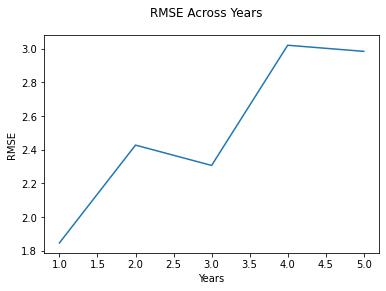

In [ ]:
def plotRMSEs(data, title="RMSE Across Years"):
  figure,ax = plt.subplots()
  ax.set_xlabel('Years')
  ax.set_ylabel('RMSE')
  figure.suptitle(title)
  
  # calculate years
  years = len(data)
  X = [i+1 for i in range(years)]

  plt.plot(X, data)

  #ax.set_xlim(plot_range)
  plt.savefig(save_path+"rmse_across_years.eps", format='eps')
  plt.show()

plotRMSEs(RMSEs_over_years)

In [ ]:
# sampling 500 times for each patient
y_samples = np.stack([model(test_X,training=True)
                   for sample in range(500)])

mean_values = []
std_values = []
for i in range(y_samples.shape[1]):
  sample_mean = y_samples[:,i,:].mean(axis=0)
  sample_std = y_samples[:,i,:].std(axis = 0,dtype=np.float64)
  mean_values.append(sample_mean)
  std_values.append(sample_std)

mean_values = np.array(mean_values)
std_values = np.array(std_values,dtype=np.float64)

print(y_samples.shape)

(500, 43, 5)


In [ ]:
# Calculate RMSE for LSTM+MC Dropout 
RMSE_samples = []
RMSE_samples_over_years = [[] for _ in range(y_samples.shape[2])] 

for i in range(y_samples.shape[0]):
  RMSE_samples.append(np.sqrt(mean_squared_error(test_Y, y_samples[i,:,:])))

  # Calculate yearly 
  for year in range(y_samples.shape[2]):
    mse_test_yearly = mean_squared_error(test_Y[:,year], y_samples[i,:,year])
    RMSE_samples_over_years[year].append(np.sqrt(mse_test_yearly))

RMSE_samples = np.array(RMSE_samples)
RMSE_samples_over_years = np.array(RMSE_samples_over_years)

print(RMSE_samples.shape)
RMSE_with_MCDropout = RMSE_samples.mean()
print(RMSE_with_MCDropout)
print(RMSE_samples_over_years.shape)
RMSE_with_MCDropout_over_years = RMSE_samples_over_years.mean(axis=1)
print(RMSE_with_MCDropout_over_years)

(500,)
2.9844564993739193
(5, 500)
[2.38590127 2.85417069 2.77628507 3.39584243 3.37399703]


In [ ]:
# SMSE
def smse(mean_values, std_values, y_test):
  N = y_test.shape[0]
  years = y_test.shape[1]
  output = []

  for year in range(years):
    currSum = 0
    for i in range(N):
      currSum+= np.square(y_test[i][year]-mean_values[i][year]) / np.square(std_values[i][year])
    
    output.append(np.sqrt((1/N) * currSum))
  return output

srmse_avg = np.mean(np.array(smse(mean_values, std_values, test_Y)))
print('SRMSE average', srmse_avg)

SRMSE average 3.0530804499108792


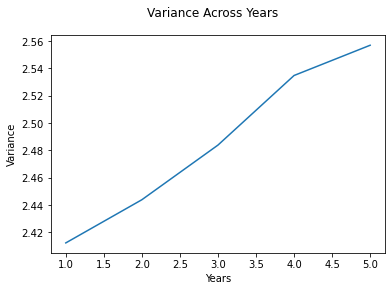

In [ ]:
def plotYearlyVariances(data, title="Variance Across Years"):
  figure,ax = plt.subplots()
  ax.set_xlabel('Years')
  ax.set_ylabel('Variance')
  figure.suptitle(title)
  
  # calculate years
  years = data.shape[-1]
  X = [i+1 for i in range(years)]
  Y = []

  for year in range(years):
    # calculate average of variances
    var = np.var(y_samples[:,:,year], axis=0)
    Y.append(np.mean(var))

  plt.plot(X, Y)

  #ax.set_xlim(plot_range)
  plt.savefig(save_path+"variance_across_years.eps", format='eps')
  plt.show()

  return Y

variances = plotYearlyVariances(y_samples)

In [ ]:
# Find variances of patients
def findMostVariablePatients(data, k=5):

  # calculate average variances
  avg_vars = np.mean(np.var(data, axis=0), axis=1)

  # give patients IDs
  avg_vars_with_IDs = []

  for id in range(avg_vars.shape[-1]):

    #calculate average RMSE
    avg_rmse = np.sqrt(mean_squared_error(test_Y[id,:],output_predicted[id,:]))

    avg_vars_with_IDs.append([id, avg_vars[id], avg_rmse])

  # sort patients according to the variance + rmse
  avg_vars_with_IDs = sorted(avg_vars_with_IDs, key=lambda patient: patient[1], reverse=True)

  # get top k variable patients
  if k > len(avg_vars_with_IDs):
    return avg_vars_with_IDs
  else:
    return avg_vars_with_IDs[:k]


def extractMostVariablePatientRMSEs(data, most_variable_patients):
  rmses = []

  # extract RMSEs of patients
  for id, var, rmse in most_variable_patients:
    avg_predicted = np.mean(data, axis=0)[id]
    actual = test_Y[id]
    rmses.append([id, var, rmse]+list(avg_predicted)+list(actual))

  return rmses

def exportMostVariablePatientRMSEs(rmses_variable_patient):
  fields = ['ID', 'Variance', 'overall_RMSE']
  years = (len(rmses_variable_patient[0])-3) // 2

  # add fields for years
  for i in range(years):
    fields.append('Predicted RMSE Y'+str(i+1))
  for i in range(years):
    fields.append('Actual RMSE Y'+str(i+1))

  with open(save_path+'variable_patients.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(rmses_variable_patient)

avg_vars_with_ids = findMostVariablePatients(y_samples, k=20)
#print(avg_vars_with_ids)
rmses_variable_patient = extractMostVariablePatientRMSEs(y_samples, avg_vars_with_ids)
exportMostVariablePatientRMSEs(rmses_variable_patient)
print(rmses_variable_patient)



[[4, 3.3526177, 1.8177278628590887, 29.455254, 29.847752, 29.546322, 29.65582, 28.908531, 30.0, 27.0, 30.0, 28.0, 27.0], [6, 3.1398299, 2.6990836212605545, 29.522642, 29.879967, 29.600384, 29.683853, 28.918785, 28.0, 27.0, 28.0, 25.0, 29.0], [15, 3.100716, 1.1045959582004163, 28.991323, 29.260357, 28.950275, 28.955084, 28.20106, 27.0, 30.0, 30.0, 29.0, 29.0], [36, 3.0500321, 1.1021754439485771, 29.0034, 29.23455, 28.958693, 28.925188, 28.170261, 29.0, 27.0, 29.0, 28.0, 29.0], [40, 3.0244298, 1.1700568545312267, 28.973671, 29.204542, 28.921593, 28.892323, 28.14203, 30.0, 30.0, 30.0, 30.0, 30.0], [13, 2.966475, 1.0918754827312491, 29.054054, 29.307955, 29.03034, 29.021055, 28.295448, 30.0, 29.0, 30.0, 30.0, 30.0], [5, 2.956934, 2.8296238049666553, 29.339636, 29.707018, 29.42308, 29.50355, 28.761158, 29.0, 27.0, 26.0, 25.0, 29.0], [30, 2.9147289, 1.3266560732654955, 29.31695, 29.557364, 29.279472, 29.278683, 28.53632, 30.0, 30.0, 27.0, 30.0, 30.0], [19, 2.8690445, 1.3870602008791422, 28.7

In [ ]:
# Export baseline and LSTIM+MC Dropout RMSEs and  LSTIM+MC Dropout variance to csv
def exportRMSEsAndVariancesToCSV(RMSEs, overall_RMSE, variances, RMSE_with_MCDropout, RMSE_with_MCDropout_over_years):
  fields = ['RMSEs', 'Overall RMSE', 'Variances', 'Avg Variance', 'RMSEs+MC Droput', 'Overall RMSE+MC Dropout']
  rows = []
  for i in range(len(RMSEs)):
    row = [RMSEs[i], None, variances[i], None, RMSE_with_MCDropout_over_years[i], None]
    if i == 0:
      row[1] = overall_RMSE
      row[3] = variances.mean()
      row[5] = RMSE_with_MCDropout
    rows.append(row)

  with open(save_path+'results.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(rows)

exportRMSEsAndVariancesToCSV(RMSEs_over_years, rmse_test, np.array(variances), RMSE_with_MCDropout, RMSE_with_MCDropout_over_years)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


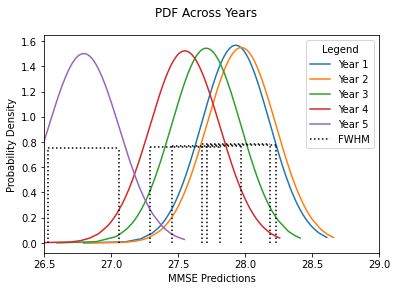

In [ ]:
def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

def plotDataPDF(data, title="PDF Across Years"):
  figure,ax = plt.subplots()
  ax.set_xlabel('MMSE Predictions')
  ax.set_ylabel('Probability Density')
  figure.suptitle(title)
  
  labels = []
  years = y_samples.shape[2]
  plot_range = [float('inf'), float('-inf')]
  plot_height = [float('-inf')] * years
  width = []

  #create legend lables
  for year in range(years):
    labels.append('Year ' + str(year+1))  
  labels.append('FWHM')

  #calcuate and plot pdf
  for year in range(years):
    #calculate means of the draws and sort asc
    X = sorted(y_samples[:,:,year].mean(axis=1))

    #calculate sample mean and stdev
    mean = np.mean(X)
    std = np.std(X)
    width.append((mean, std))


    #create a normal distribution plot
    Y = norm.pdf(X, loc=mean, scale=std)
    plt.plot(X, Y)

    #calulcate the confidence interval
    start, end = norm.interval(0.95, loc=mean, scale=std) - mean
    
    #plot the confidence interval
    #plt.fill_between(X, (Y+start), (Y+end), alpha=0.2)

    #get min/max for plot range
    plot_range[0] = min(min(X), plot_range[0])
    plot_range[1] = max(max(X), plot_range[1])
    plot_height[year] = max(Y)
  
  for year, (mean, std) in enumerate(width):
    start = mean-std
    end = mean+std
    plt.plot([start, end], [plot_height[year]/2, plot_height[year]/2], linestyle=':', color='black')
    plt.plot([start, start], [0, plot_height[year]/2], linestyle=':', color='black')
    plt.plot([end, end], [0, plot_height[year]/2], linestyle=':', color='black')

  ax.set_xlim([26.5,29])
  plt.legend(labels, title = "Legend") 
  plt.savefig(save_path+'pdf.eps', format='eps')
  plt.show()

plotDataPDF(y_samples)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not

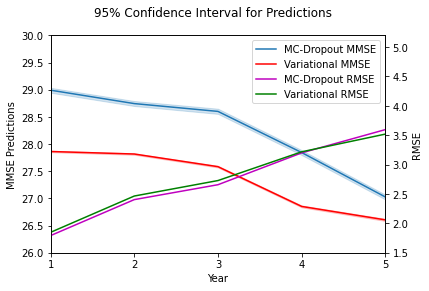

In [ ]:
def CIPlot2D(data, title="95% Confidence Interval for  Predictions"):
  figure,ax = plt.subplots()
  ax.set_xlabel('Time')
  ax.set_ylabel('MMSE Predictions')
  figure.suptitle(title)
  labels = ['MMSE over Time']
  years = data.shape[1]
  
  # create axes
  X = []
  Y = []
  for i in range(data.shape[0]):
    for year in range(years):
      X.append(year+1)
      Y.append(data[i][year])

  # create lineplot
  sns.lineplot(X, Y, ci=95)
  ax.set_xticks(np.arange(0, years+1,1))
  ax.set_xlim([X[0], X[-1]])
  plt.legend(labels, title = "Legend") 
  plt.savefig(save_path+"ci-plot-2d.eps", format='eps')
  plt.show()

def CIPlot3DTwoLines(data1, data2, baseline_yearly_rmse, bayesian_yearly_rmse,  title="95% Confidence Interval for Predictions"):
  figure,ax = plt.subplots()
  ax.set_xlabel('Year')
  ax.set_ylabel('MMSE Predictions')
  figure.suptitle(title)
  labels = ['MC-Dropout MMSE', 'Variational MMSE', 'MC-Dropout RMSE', 'Variational RMSE',]
  years = data1.shape[2]
  
  # twin object for two different y-axis on the sample plot
  ax2=ax.twinx()
  ax2.set_ylabel('RMSE')

  # create axes
  X_years = np.arange(1, years+1,1)
  X = []
  Y_baseline_mmse = []
  Y_bayesian_mmse = []

  for i in range(data1.shape[0]):
    for patient in range(data1.shape[1]):
      for year in range(years):
        # get years
        X.append(year+1)

        # get MMSE scores
        Y_baseline_mmse.append(data1[i][patient][year])
        Y_bayesian_mmse.append(data2[i][patient][year])

  # create lineplot
  ax = sns.lineplot(X, Y_baseline_mmse, ci=95, ax=ax, label=labels[0])
  ax = sns.lineplot(X, Y_bayesian_mmse, ci=95, color='red', ax=ax, label=labels[1])

  ax2.plot(X_years, baseline_yearly_rmse, color='m', label=labels[2])
  ax2.plot(X_years, bayesian_yearly_rmse, color='green', label=labels[3])
  ax.set_xticks(X_years)
  ax.set_xlim([X_years[0], X_years[-1]])
  ax.set_ylim([26, 30])
  ax2.set_ylim([1.5, 5.2])

  # set legend
  lines_1, labels_1 = ax.get_legend_handles_labels()
  lines_2, labels_2 = ax2.get_legend_handles_labels()
  labels = labels_1 + labels_2
  lines = lines_1 + lines_2
  ax.legend(lines, labels)

  plt.savefig(save_path+"ci_plot.eps", format="eps")
  plt.savefig(save_path+"ci_plot.pdf")
  plt.show()

  def CIPlot3D(data, title="95% Confidence Interval for Predictions"):
    figure,ax = plt.subplots()
    ax.set_xlabel('Time')
    ax.set_ylabel('MMSE Predictions')
    figure.suptitle(title)
    labels = ['MMSE over Time']
    years = data.shape[2]


    
    # create axes
    X = []
    Y = []
    for i in range(data.shape[0]):
      for patient in range(data.shape[1]):
        for year in range(years):
          X.append(year+1)
          Y.append(data[i][patient][year])

    # create lineplot
    sns.lineplot(X, Y, ci=95)
    ax.set_xticks(np.arange(0, years+1,1))
    ax.set_xlim([X[0], X[-1]])
    plt.legend(labels, title = "Legend") 
    plt.savefig(save_path+"ci_plot_3d.cdf", format="cdf")
    plt.show()


def loadPickleFile(path):
  infile = open(path,'rb')
  pfile = pickle.load(infile)
  return pfile
# plot a all samples for a single patient
#CIPlot2D(y_samples[:,0,:])

# plot all sample for all patients
pickle_path = '/content/drive/MyDrive/ADPM-Uncertainty/ADPM-uncertainty-quantification-main//Pickle Files/y_sample_5_years.pickle'
bayesian_yearly_rmse = [1.8483315135143095, 2.465915259620037, 2.7294490367228663, 3.218482145256664, 3.519989153238404]
CIPlot3DTwoLines(y_samples, loadPickleFile(pickle_path), RMSEs_over_years, bayesian_yearly_rmse)




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


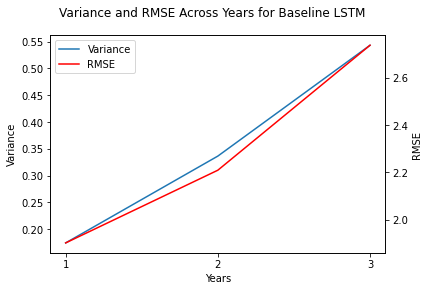

In [ ]:
# Plot variance and RMSES for one model

def plotComparativeData(vars, rmses, title=""):
  pre_title = "Variance and RMSE Across Years "
  figure,ax = plt.subplots()
  ax.set_xlabel('Years')
  ax.set_ylabel('Variance')
  # twin object for two different y-axis on the sample plot
  ax2=ax.twinx()
  ax2.set_ylabel('RMSE')
  figure.suptitle(pre_title+title)
  labels1 = ['Variance']
  labels2 = ['RMSE']
  # calculate years
  years = vars.shape[-1]
  
  # set ticks
  ax.set_xticks(np.arange(0, years+1,1))

  #set axis
  X = [i+1 for i in range(years)]
  Y1 = vars
  Y2 = rmses

  ax.plot(X, Y1, label=labels1[0])
  ax2.plot(X, Y2, color="red", label=labels2[0])

  #ax.set_xlim(plot_range)
  
  # set legend
  lines_1, labels_1 = ax.get_legend_handles_labels()
  lines_2, labels_2 = ax2.get_legend_handles_labels()
  lines = lines_1 + lines_2
  labels = labels_1 + labels_2
  ax.legend(lines, labels, loc=0)

  plt.savefig(save_path+"var_and_rmse.eps", format='eps')
  plt.show()

# 3-year baseline
vars = np.array([0.1742545, 0.33625814, 0.54304653])
rmses = np.array([1.902625233,2.209555495, 2.736996216])


plotComparativeData(vars, rmses, title='for Baseline LSTM')

In [ ]:
mse_test_MC = mean_squared_error(test_Y,mean_values)
rmse_test_MC = np.sqrt(mse_test_MC)
print('RMSE-MC')
print(rmse_test_MC)
print('MSE-MC')
print(mse_test_MC)

RMSE-MC
2.7630342555753105
MSE-MC
7.63435829748261


In [ ]:
#compile_model_MC
model_MC = create_model_MC()
model_MC.compile(loss = 'mean_squared_error', optimizer = Adam(learning_rate = 0.01), metrics = [metrics.RootMeanSquaredError()])
checkpoint = ModelCheckpoint('/content/drive/MyDrive/ADPM-Uncertainty/ADPM-uncertainty-quantification-main/model_MC_weights.h5', monitor='val_loss', save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
training_history = model_MC.fit(train_X,train_Y,batch_size = 8,epochs = 400,callbacks=[checkpoint,earlystopping],validation_data=(test_X,test_Y),shuffle= True)

In [ ]:
# # create and fit the LSTM network
# models = []

# def createModels():
#     for i in range(len(labels)-2):
#         model = Sequential()
#         model.add(LSTM(4, input_shape=train_X.shape[1:]))
#         model.add(Dense(train_Y.shape[1]))
#         model.compile(loss='mean_squared_error', optimizer='adam')
#         model.fit(train_X, train_Y[:,0,i], epochs=100, batch_size=1, verbose=1)
#         models.append(model)

# createModels()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras import metrics

# Function to create model
def create_model(LSTM_units = 4, dropout_rate = 0.1, optimizer_select = SGD(learning_rate = 0.01)):
  model = Sequential()
  model.add(LSTM(units = LSTM_units,input_shape=train_X.shape[1:], activation='tanh'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(2, activation=  'relu'))
  #compile_model
  model.compile(loss = 'mean_squared_error', optimizer = optimizer_select, metrics = [metrics.RootMeanSquaredError()])
  return model
#create model
model = KerasRegressor(build_fn = create_model, verbose=1)
#grid serach params
optimizers_list = [Adam(learning_rate = 0.01),Adam(learning_rate = 0.001),Adam(learning_rate = 0.0001)]
batch_size = [8,16,32,64]
epochs = [20,30,50,70]
dropout_rate = [0.1,0.3,0.5]
LSTM_units = [4,8,16,32]

param_grid = dict(LSTM_units = LSTM_units, dropout_rate = dropout_rate, optimizer_select = optimizers_list, batch_size = batch_size, epochs = epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(train_X, train_Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Epoch 1/70
55/55 [==============================] - 2s 3ms/step - loss: 540.5401 - root_mean_squared_error: 23.2495
Epoch 2/70
55/55 [==============================] - 0s 3ms/step - loss: 320.6570 - root_mean_squared_error: 17.9069
Epoch 3/70
55/55 [==============================] - 0s 3ms/step - loss: 192.4152 - root_mean_squared_error: 13.8714
Epoch 4/70
55/55 [==============================] - 0s 3ms/step - loss: 114.6865 - root_mean_squared_error: 10.7092
Epoch 5/70
55/55 [==============================] - 0s 4ms/step - loss: 71.6180 - root_mean_squared_error: 8.4627
Epoch 6/70
55/55 [==============================] - 0s 3ms/step - loss: 47.2196 - root_mean_squared_error: 6.8716
Epoch 7/70
55/55 [==============================] - 0s 3ms/step - loss: 35.6577 - root_mean_squared_error: 5.9714
Epoch 8/70
55/55 [==============================] - 0s 3ms/step - loss: 31.0522 - root_mean_squared_error: 5.5724
Epoch 9/70
55/55 [==============================] - 0s 3ms/step - loss: 27.0406 

In [ ]:
# make predictions
predictions = []

for i in range(len(models)):
    testPredict = models[i].predict(test_X)
    predictions.append(testPredict)

In [ ]:
# calculate root mean squared error and absolute value error
for j in range(train_Y.shape[1]):
    print('------------- timestep', j)
    for i, prediction in enumerate(predictions):
        currTimestepAndTest = np.squeeze(test_Y[:,j:j+1,i:i+1], axis=1)
        print('-- Test ' + labels[i+2])
        testScore = np.sqrt(mean_squared_error(currTimestepAndTest, prediction[:,j:j+1]))
        print('RMSE Score: %.2f' % (testScore))
        testScore = mean_absolute_error(currTimestepAndTest, prediction[:,j:j+1])
        print('MAE Score: %.2f' % (testScore))

------------- timestep 0
-- Test ADAS11
RMSE Score: 4.53
MAE Score: 3.34
-- Test ADAS13
RMSE Score: 6.91
MAE Score: 5.27
-- Test MMSE
RMSE Score: 2.56
MAE Score: 2.03


In [ ]:
#Create Bayesian LSTM class from varioational estimator decorator 
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        #TODO: check parameters at: https://github.com/piEsposito/blitz-bayesian-deep-learning/blob/master/doc/layers.md#class-BayesianLSTM 
        self.lstm_1 = BayesianLSTM(12, 32)
        self.linear1 = nn.Linear(32, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16,3)

    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear1(x_)
        x_ = self.relu(x_)
        x_ = self.linear2(x_)
        x_ = self.relu(x_)
        
        return x_

In [ ]:
#Create objects
train_X = torch.tensor(train_X[:,:]).float()
train_Y = torch.tensor(train_Y[:,:]).float()
test_X = torch.tensor(test_X[:,:]).float()
test_Y = torch.tensor(test_Y[:,:]).float()
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
ds = torch.utils.data.TensorDataset(train_X, train_Y)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

torch.Size([412, 2, 12])
torch.Size([412, 3])
torch.Size([103, 2, 12])
torch.Size([103, 3])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct 

In [ ]:
# train loop

iteration = 0
epochs = 50
for epoch in range(epochs):
    running_loss = 0.0
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()

        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()

        iteration += 1
        if iteration%250==0:
            preds_test = net(test_X)
            loss_test = criterion(preds_test, test_Y)
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))
    
    #print('[%d] loss: %.3f' % (epoch + 1, running_loss / 2000))

print('Finished Training')

Iteration: 250 Val-loss: 9.9001
Iteration: 500 Val-loss: 8.5846
Iteration: 750 Val-loss: 12.2389
Iteration: 1000 Val-loss: 10.4711
Iteration: 1250 Val-loss: 8.2572
Iteration: 1500 Val-loss: 10.6245
Iteration: 1750 Val-loss: 9.7058
Iteration: 2000 Val-loss: 10.9672
Iteration: 2250 Val-loss: 10.5395
Iteration: 2500 Val-loss: 10.2170
Finished Training


In [ ]:
'''preds_test = net(test_X).unsqueeze(1)
print(preds_test.shape)
print(preds_test)'''
preds_test = net(test_X)
print(preds_test.shape)
print(preds_test)
preds_test = net(test_X)
print(preds_test.shape)
print(preds_test)

torch.Size([103, 3])
tensor([[27.9211, 27.1910, 26.1219],
        [27.7143, 26.9733, 25.9419],
        [27.4580, 26.7382, 25.6839],
        [27.7891, 27.0219, 25.9907],
        [27.5328, 26.8173, 25.7584],
        [27.8689, 27.1478, 26.0732],
        [27.5910, 26.8406, 25.8072],
        [27.5129, 26.7801, 25.7452],
        [27.4271, 26.6970, 25.6383],
        [27.7277, 26.9643, 25.9316],
        [27.6229, 26.9035, 25.8211],
        [27.3492, 26.5614, 25.5250],
        [27.5378, 26.8511, 25.7692],
        [27.7189, 27.0519, 25.9579],
        [27.5727, 26.7767, 25.7595],
        [27.5654, 26.9050, 25.8176],
        [27.4248, 26.7539, 25.6790],
        [27.6876, 26.9439, 25.9106],
        [27.3510, 26.6429, 25.6054],
        [27.6624, 26.9727, 25.9004],
        [27.6961, 27.0094, 25.9168],
        [27.4025, 26.7277, 25.6402],
        [27.8380, 27.1297, 26.0491],
        [27.4910, 26.7826, 25.6875],
        [27.6953, 26.9255, 25.8983],
        [27.6259, 26.9590, 25.8743],
        [27.5861,